## 운전자 이상행동 탐지

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# set random seed
seed(10)
tf.random.set_seed(10)


Using TensorFlow backend.


# 데이터 로딩 및 커서포인터 설정

In [2]:

import sqlite3 as s

conn1 = s.connect('data/base4.sqlite') 
conn2 = s.connect('data/anomal4.sqlite')
with open('data/base4.sqlite', 'r') as f:
    train = conn1.cursor()
with open('data/anomal4.sqlite', 'r') as f:
    test = conn2.cursor()

In [3]:

train = pd.read_sql_query("SELECT hspeed,stime FROM MILANE WHERE hspeed > 10 ",conn1)
test = pd.read_sql_query("SELECT hspeed,stime FROM MILANE WHERE hspeed > 10 ",conn2)

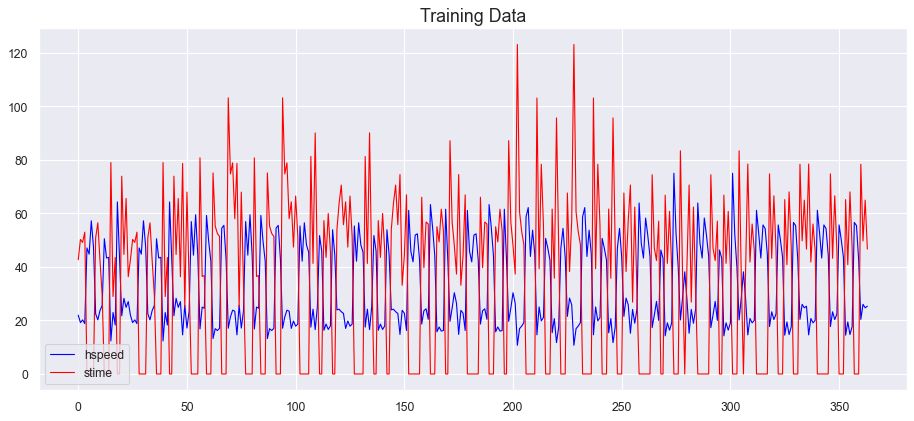

In [4]:
# train data plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['hspeed'], label='hspeed', color='blue', animated = True, linewidth=1)
ax.plot(train['stime'], label='stime', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Training Data', fontsize=16)
plt.show()

In [5]:
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (364, 2)
Test dataset shape: (360, 2)


In [6]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
X_train
scaler_filename = "data/real_scaler_data"
joblib.dump(scaler, scaler_filename)

['data/real_scaler_data']

In [7]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (364, 1, 2)
Test data shape: (360, 1, 2)


In [8]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(24, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(12, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(12, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(24, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [9]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 24)             2592      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 12)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 12)             1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 24)             3552      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 2)              50  

In [10]:
# fit the model to the data
nb_epochs = 200
batch_size = 20
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size
                ).history

Epoch 1/200
364/364 [==============================] - 1s 3ms/step - loss: 0.2983
Epoch 2/200
364/364 [==============================] - 0s 93us/step - loss: 0.2787
Epoch 3/200
364/364 [==============================] - 0s 90us/step - loss: 0.2586
Epoch 4/200
364/364 [==============================] - 0s 90us/step - loss: 0.2428
Epoch 5/200
364/364 [==============================] - 0s 88us/step - loss: 0.2320
Epoch 6/200
364/364 [==============================] - 0s 99us/step - loss: 0.2253
Epoch 7/200
364/364 [==============================] - 0s 104us/step - loss: 0.2213
Epoch 8/200
364/364 [==============================] - 0s 112us/step - loss: 0.2190
Epoch 9/200
364/364 [==============================] - 0s 110us/step - loss: 0.2171
Epoch 10/200
364/364 [==============================] - 0s 112us/step - loss: 0.2159
Epoch 11/200
364/364 [==============================] - 0s 112us/step - loss: 0.2147
Epoch 12/200
364/364 [==============================] - 0s 110us/step - loss: 0.2

364/364 [==============================] - 0s 101us/step - loss: 0.0092
Epoch 98/200
364/364 [==============================] - 0s 99us/step - loss: 0.0084
Epoch 99/200
364/364 [==============================] - 0s 101us/step - loss: 0.0081
Epoch 100/200
364/364 [==============================] - 0s 99us/step - loss: 0.0084
Epoch 101/200
364/364 [==============================] - 0s 104us/step - loss: 0.0079
Epoch 102/200
364/364 [==============================] - 0s 101us/step - loss: 0.0083
Epoch 103/200
364/364 [==============================] - 0s 99us/step - loss: 0.0085
Epoch 104/200
364/364 [==============================] - 0s 104us/step - loss: 0.0086
Epoch 105/200
364/364 [==============================] - 0s 104us/step - loss: 0.0082
Epoch 106/200
364/364 [==============================] - 0s 104us/step - loss: 0.0075
Epoch 107/200
364/364 [==============================] - 0s 104us/step - loss: 0.0083
Epoch 108/200
364/364 [==============================] - 0s 110us/step - 

364/364 [==============================] - 0s 104us/step - loss: 0.0043
Epoch 193/200
364/364 [==============================] - 0s 99us/step - loss: 0.0035
Epoch 194/200
364/364 [==============================] - 0s 99us/step - loss: 0.0048
Epoch 195/200
364/364 [==============================] - 0s 96us/step - loss: 0.0041
Epoch 196/200
364/364 [==============================] - 0s 99us/step - loss: 0.0034
Epoch 197/200
364/364 [==============================] - 0s 99us/step - loss: 0.0038
Epoch 198/200
364/364 [==============================] - 0s 101us/step - loss: 0.0032
Epoch 199/200
364/364 [==============================] - 0s 101us/step - loss: 0.0038
Epoch 200/200
364/364 [==============================] - 0s 99us/step - loss: 0.0039


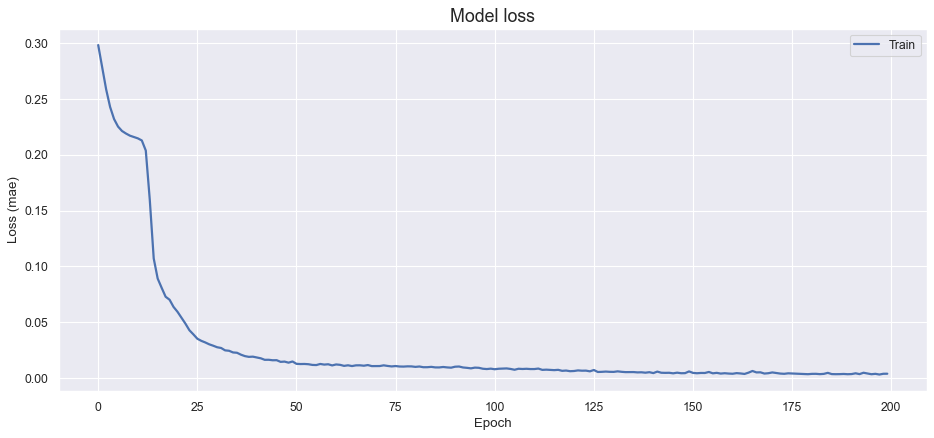

In [11]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)

ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function

C:\Users\jkn17\anaconda3\envs\test\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.03)

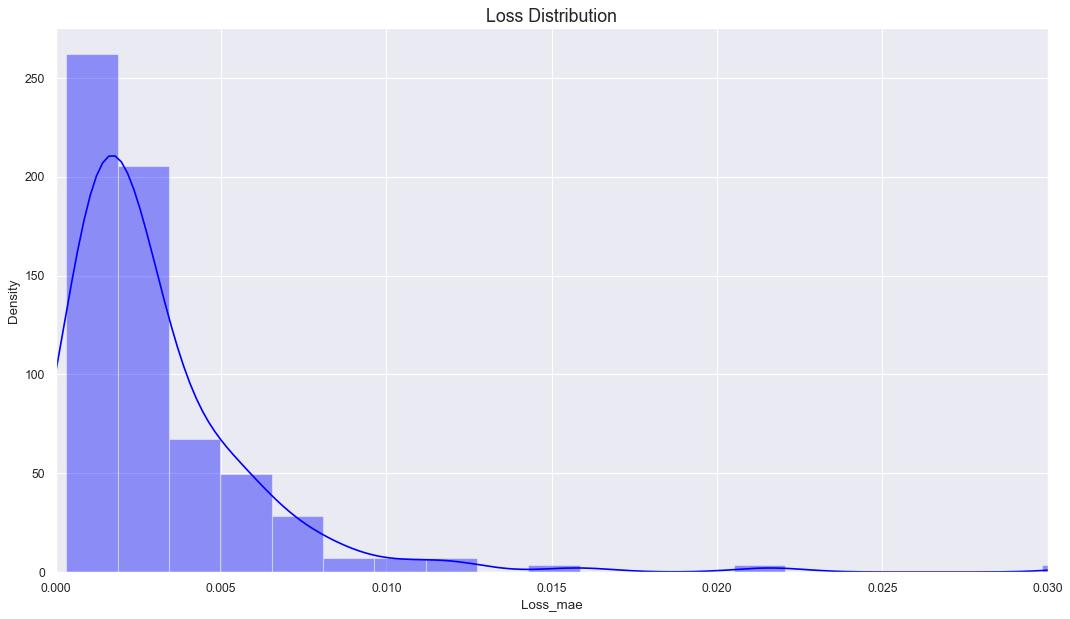

In [12]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.03])

In [13]:

print('anomaly threshold = {}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

anomaly threshold = 0.0313720665872097


,Loss_mae,Threshold,Anomaly
0,0.002430,0.031372,False
1,0.001995,0.031372,False
2,0.002069,0.031372,False
3,0.001261,0.031372,False
4,0.000533,0.031372,False


C:\Users\jkn17\anaconda3\envs\test\lib\site-packages\pandas\plotting\_matplotlib\core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


<AxesSubplot:>

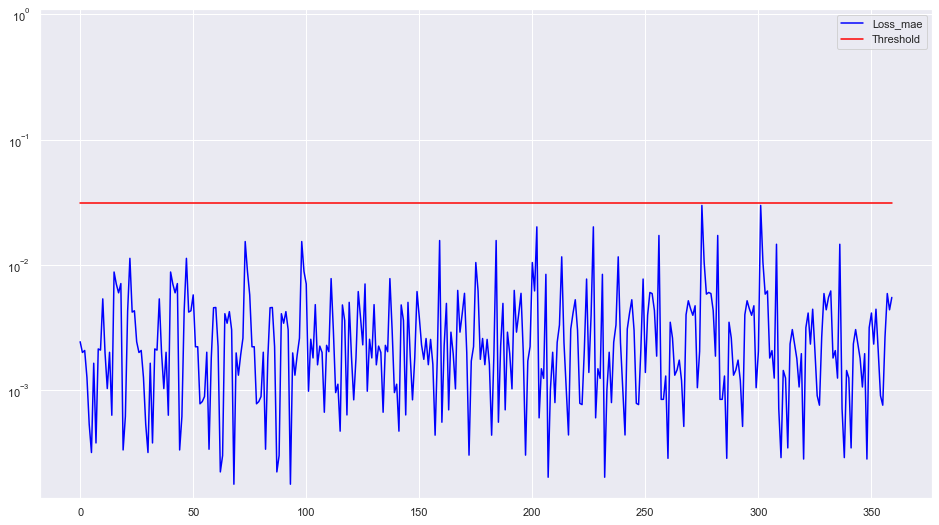

In [14]:
# test set에 대한 결과
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

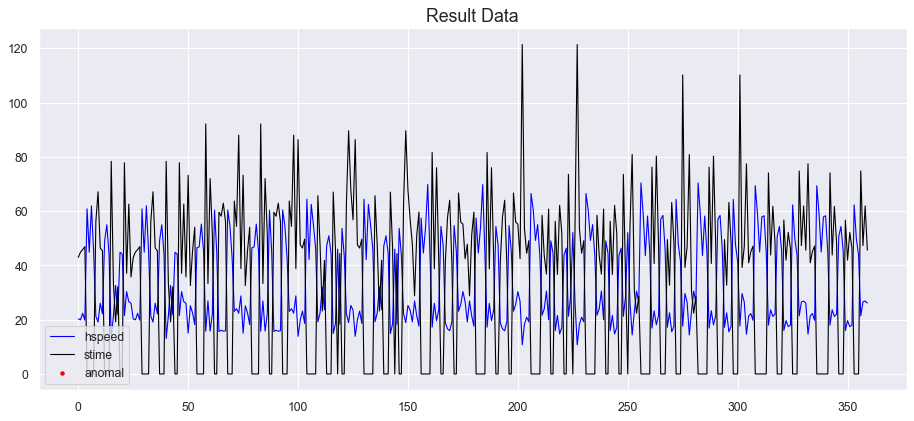

In [15]:
#whole test data
test_ = pd.read_sql_query("SELECT hspeed,stime FROM MILANE WHERE hspeed > 10 ",conn2)

#make plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['hspeed'], label='hspeed', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['hspeed'].index,test_[scored['Anomaly']==1]['hspeed'],label='anomal',marker='.', color='red')
ax.plot(test_['stime'], label='stime', color='black', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['stime'].index,test_[scored['Anomaly']==1]['stime'], marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('Result Data', fontsize=16)

plt.show()

In [16]:
# save all model information, including weights, in h5 format
model.save("model.h5")
print("Model saved")

Model saved
